# Binary Classification Modeling

**Refer to `EDA_and_modeling.ipynb` for exploratory data analysis and NLP modeling with 3 classes.** 

In this notebook, I will attempt to build a model to classify tweet by sentiment.  This notebook will differe in that negative and neutral tweets will be classified together. I will also remove some of the added features to see if that will help in predicting sentiment.

Let's discuss why binary modeling is useful and applicable to this dataset.

Binary modeling is useful here because of the stark class imbalance in this dataset. There were simply not enough negative tweets for any of the models to perform well in classifying negative tweets. Without acquiring more data or creating enough synthetic, negative tweets, the class imbalance will limit how accurate the model can be.

The business purpose for having two classes is simple. A company like Apple or Google likely just needs to know if if the tweet is positive or not positive. There may not be a need to distinguish between negative and neutral. If we know that an individual has tweeted something positive about a brand or product, then it's reasonable to assume that they have a favorable opinion about that product. Somebody who has a favorable opinion is likely to be a customer as well. [This blog](https://mention.com/en/blog/online-reviews/) discusses a few of the reasons why somebody sharing their positive opinion is good for a company, and it states that people who have good things to say are more likely to share their positive opinion. This means that the neutral/negative tweets should be the focus of a company. We want the NLP model to detect those negative/neutral tweets because those may not be guaranteed customers. Big Tech companies want to identify those individuals that may be reticent to use or purchase their product so they can understand how they should market themselves such that they can increase their customer base.

Per [market research](https://marketing.twitter.com/en_gb/insights/twitters-audience-is-hugely-influential-heres-what-it-means-for-brands) from Twitter:
- 3 in 4 poeple said Twitter users were the first people they looked to for advice
- 9 in 10 people said they changed their opinion aobut a purchase bedcause of advice that was given to them by someone they knew on Twitter

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 200)
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import string
import nltk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from bs4 import BeautifulSoup

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_binary = pd.read_csv('binary_tweets.csv')
pd.set_option('max_columns', None)
df_binary.groupby('sentiment').describe()

hashtag_count                                                \
                  count      mean       std  min  25%  50%  75%   max   
sentiment                                                               
0                5341.0  1.758285  1.116353  0.0  1.0  1.0  2.0  12.0   
1                2989.0  1.686183  0.969004  0.0  1.0  1.0  2.0  10.0   

          mention_count                                               \
                  count      mean       std  min  25%  50%  75%  max   
sentiment                                                              
0                5341.0  0.752106  0.905020  0.0  0.0  1.0  1.0  8.0   
1                2989.0  0.740381  0.853871  0.0  0.0  1.0  1.0  7.0   

          weblink_count                                               \
                  count      mean       std  min  25%  50%  75%  max   
sentiment                                                              
0                5341.0  0.457218  0.529199  0.0  0.0  0.0  1.0  3.0   
1                2989.0  0.407494  0.503559  0.0  0.0  0.0  1.0  2.0   

          tweet_length                                                    \
                 count       mean       std  min   25%   50%   75%   max   
sentiment                                                                  
0               5341.0  17.340573  4.926567  4.0  14.0  17.0  21.0  32.0   
1               2989.0  17.892606  4.879626  4.0  14.0  18.0  22.0  33.0   

          punct_count                                                
                count      mean       std  min  25%  50%  75%   max  
sentiment                                                            
0              5341.0  3.264183  2.425220  0.0  1.0  3.0  5.0  22.0  
1              2989.0  3.435597  2.326356  0.0  2.0  3.0  5.0  19.0

In [3]:
pd.set_option('max_columns', 10)
df_binary.head(20)

tweet  \
0                 .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.   
1    @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                             @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4                @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)   
5   @teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd   
6     #SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan   
7              Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB   
8                                                       Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear   
9                           Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1. #fail   
10                 Find & Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wait til the Android app comes out.   
11         Foursquare ups the game, just in time for #SXSW http://j.mp/grN7pK) - Still prefer @Gowalla by far, best looking Android app to date.   
12    Gotta love this #SXSW Google Calendar featuring top parties/ show cases to check out. RT @hamsandwich via @ischafer =>http://bit.ly/aXZwxB   
13                                                                             Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l   
14                                                            haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw   
15                                                   Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw   
16              I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone   
17                Just added my #SXSW flights to @planely. Matching people on planes/airports. Also downloaded the @KLM iPhone app, nicely done.   
18                        Must have #SXSW app! RT @malbonster: Lovely review from Forbes for our SXSW iPad app Holler Gram - http://t.co/g4GZypV   
19                                    Need to buy an iPad2 while I'm in Austin at #sxsw. Not sure if I'll need to Q up at an Austin Apple store?   

                      brand_product  sentiment  \
0                            iPhone          0   
1                iPad or iPhone App          1   
2                              iPad          1   
3                iPad or iPhone App          0   
4                            Google          1   
5                              iPad          0   
6                           Android          1   
7                iPad or iPhone App          1   
8                             Apple          1   
9                           Android          1   
10                      Android App          1   
11                      Android App          1   
12  Other Google product or service          1   
13               iPad or iPhone App          1   
14               iPad or iPhone App          1   
15                             iPad          0   
16                           iPhone          0   
17               iPad or iPhone App          1   
18               iPad or iPhone App          1   
19                            

Let's take a look at the value counts for weblinks and punctuation count.

In [4]:
df_binary['weblink_count'].value_counts()

0    4769
1    3466
2      91
3       4
Name: weblink_count, dtype: int64

In [5]:
df_binary['punct_count'].value_counts()

2     1607
3     1454
1     1324
4     1111
5      805
0      624
6      609
7      345
8      172
9      128
10      71
11      33
12      18
14       8
13       7
15       5
16       3
22       2
18       1
20       1
21       1
19       1
Name: punct_count, dtype: int64

We saw in the `EDA_and_modeling` notebook that the punctuation count did not have much variance between sentiments. This means that by introducting this feature we have likely introduced more noise in the data that makes it more difficult to predict.  When we look at the value counts for the number of weblinks in a tweet, we see that more than half of the tweets have 0 weblinks. It's also the case that some tweets have an actual URL while other tweets had a URL replaced with the word '{link}'. Given that we can't immediately decipher what each of those links reference, it's difficult to determine whether it adds or detracts from the sentiment of the tweet. This may be another variable that only introduces more noise.  

In [6]:
df_binary.sentiment.value_counts()

0    5341
1    2989
Name: sentiment, dtype: int64

In [8]:
###create test and training sets with binary categories

tfidf_vec_bin = TfidfVectorizer()
X_train, X_test, y_train, y_test = train_test_split(df_binary.drop(labels=['sentiment'], axis=1), 
                                                    df_binary['sentiment'], 
                                                    test_size=0.3, stratify=df_binary['sentiment'],
                                                    random_state=123)


###Create sparse matrices using tokenized tweets
X_train_sparse = tfidf_vec_bin.fit_transform(X_train['tweet_tokens'])
X_test_sparse = tfidf_vec_bin.transform(X_test['tweet_tokens'])

In [10]:
#Log transform tweet length and then standard scale remaining added features
X_train['tweet_length'] = X_train['tweet_length'].map(lambda x: np.log(x))
X_test['tweet_length'] = X_test['tweet_length'].map(lambda x: np.log(x))

scaler = StandardScaler()
train_af_scaled = pd.DataFrame(scaler.fit_transform(X_train[['hashtag_count', 'mention_count', 
                                                             'tweet_length']]))
train_af_scaled.columns = ['hashtags_count_scaled', 'mentions_count_scaled', 'tweet_len_log_scaled']

test_af_scaled = pd.DataFrame(scaler.transform(X_test[['hashtag_count', 'mention_count', 'tweet_length']]))
test_af_scaled.columns = ['hashtags_count_scaled', 'mentions_count_scaled', 'tweet_len_log_scaled']


In [9]:
X_bin_af = pd.concat([added_feats, df_binary], axis=1)

In [11]:
#train test split for just TF-IDF matrix
y_binary = df_binary['sentiment']

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_tfidf_df_bin, y_binary, test_size=0.3, 
                                                                    stratify=y_binary, random_state=123)

In [12]:
#train test split for added features matrix
X_train_bin_af, X_test_bin_af, y_train_bin_af, y_test_bin_af = train_test_split(X_bin_af, y_binary, 
                                                                                test_size=0.3, 
                                                                                stratify=y_binary, 
                                                                                random_state=123)

In [14]:
#Resetting indices so that scaled features can be added back to training TF-IDF matrix
X_train_af_drop = X_train_bin_af.drop(columns = ['hashtag_count', 'mention_count', 'tweet_length'])
d = X_train_af_drop.reset_index()
e = train_af_transformed
f = pd.concat([d, e], axis=1)
f.set_index(d['level_0'].values, inplace=True)
X_train_bin_af_scaled = f
X_train_bin_af_scaled.drop(columns=['level_0'], inplace=True)

In [15]:
#Reseeting indices so that scaled features can be added back to test TF-IDF matrix
X_test_af_drop = X_test_bin_af.drop(columns = ['hashtag_count', 'mention_count', 'tweet_length'])
a = X_test_af_drop.reset_index()
b = test_af_transformed
c = pd.concat([b, a], axis=1)
c.set_index(a['level_0'].values, inplace=True)
X_test_bin_af_scaled = c
X_test_bin_af_scaled.drop(columns=['level_0'], inplace=True)

## Modeling

For modeling purposes, we will examine and evaluate the same three algorithms as before:
- Multinomial Bayes
- Random Forests
- Support Vector Machines

### Multinomial Naive Bayes

In [20]:
mnb = MultinomialNB()
mnb.fit(X_train_bin, y_train_bin)

MultinomialNB()

In [22]:
mnb_cv_mean = np.mean(cross_val_score(mnb, X_train_bin, y_train_bin, cv=5, scoring='accuracy', n_jobs=-1))

In [23]:
print(f"Training Accuracy: {mnb.score(X_train_bin, y_train_bin)}")
print(f"Mean Cross Validation Training Accuracy: {mnb_cv_mean}")
print(f"Testing Accuracy: {mnb.score(X_test_bin, y_test_bin)}")

Training Accuracy: 0.7849425484479506
Mean Cross Validation Training Accuracy: 0.6858160594155163
Testing Accuracy: 0.687875150060024


In [24]:
mnb_2 = MultinomialNB(alpha=2, fit_prior=False)
mnb_2.fit(X_train_bin, y_train_bin)

MultinomialNB(alpha=2, fit_prior=False)

In [25]:
mnb2_cv_mean = np.mean(cross_val_score(mnb_2, X_train_bin, y_train_bin, cv=5, scoring='accuracy', n_jobs=-1))

In [26]:
print(f"Training Accuracy: {mnb_2.score(X_train_bin, y_train_bin)}")
print(f"Mean Cross Validation Training Accuracy: {mnb2_cv_mean}")
print(f"Testing Accuracy: {mnb_2.score(X_test_bin, y_test_bin)}")

Training Accuracy: 0.8188989881666953
Mean Cross Validation Training Accuracy: 0.6854731532230683
Testing Accuracy: 0.6994797919167667


In [60]:
print(classification_report(y_test_bin, mnb_2.predict(X_test_bin)))

              precision    recall  f1-score   support

           0       0.72      0.86      0.79      1602
           1       0.62      0.42      0.50       897

    accuracy                           0.70      2499
   macro avg       0.67      0.64      0.64      2499
weighted avg       0.69      0.70      0.68      2499



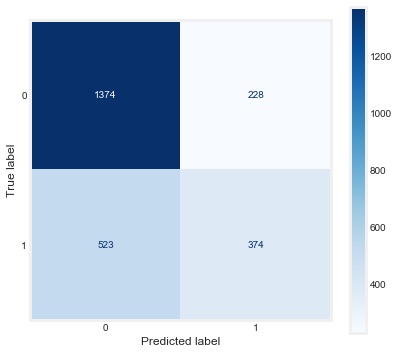

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(mnb_2, X_test_bin, y_test_bin, cmap='Blues', ax=ax)

In [28]:
mnb_af = MultinomialNB()
mnb_af.fit(X_train_bin_af, y_train_bin_af)

MultinomialNB()

In [29]:
mnb_af_cv_mean = np.mean(cross_val_score(mnb_af, X_train_bin_af, 
                                         y_train_bin_af, cv=5, scoring='accuracy', n_jobs=-1))

In [31]:
print(f"Training Accuracy: {mnb_af.score(X_train_bin_af, y_train_bin_af)}")
print(f"Mean Cross Validation Training Accuracy: {mnb2_cv_mean}")
print(f"Testing Accuracy: {mnb_af.score(X_test_bin_af, y_test_bin_af)}")

Training Accuracy: 0.7208026067569885
Mean Cross Validation Training Accuracy: 0.6854731532230683
Testing Accuracy: 0.6718687474989996


For the Naive Bayes algorithm, we see a noticeable improvement for binary classification compared to the models that were trained on 3 classes. The Naive Bayes model with default hyperparameters also significantly reduced overfitting. Using the optimized hyperparameters from the GridSearch model, we increased the accuracy by 1% for the binary problem.

The Naive Bayes model seems to be very good at predicting neutral/negative tweets, but struggles with positive tweets. The added features here decreased accuracy by 1% so it seems that even with scaling and log transfomations the added features end up just introducing noise into the dataset.

### Random Forests

In [32]:
rfc = RandomForestClassifier()
rfc.fit(X_train_bin, y_train_bin)

RandomForestClassifier()

In [34]:
rfc_cv_mean = np.mean(cross_val_score(rfc, X_train_bin, y_train_bin, cv=5, scoring='accuracy', n_jobs=-1))

In [35]:
print(f"Training Accuracy: {rfc.score(X_train_bin, y_train_bin)}")
print(f"Mean Cross Validation Training Accuracy: {rfc_cv_mean}")
print(f"Testing Accuracy: {rfc.score(X_test_bin, y_test_bin)}")

Training Accuracy: 0.9945120905505059
Mean Cross Validation Training Accuracy: 0.7168566393429371
Testing Accuracy: 0.7054821928771509


In [62]:
print(classification_report(y_test_bin, rfc.predict(X_test_bin)))

              precision    recall  f1-score   support

           0       0.72      0.89      0.79      1602
           1       0.65      0.38      0.48       897

    accuracy                           0.71      2499
   macro avg       0.69      0.63      0.64      2499
weighted avg       0.70      0.71      0.68      2499



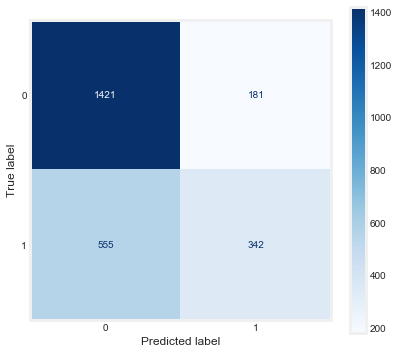

In [64]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(rfc, X_test_bin, y_test_bin, cmap='Blues', ax=ax)

In [48]:
rfc_af = RandomForestClassifier()
rfc_af.fit(X_train_bin_af_scaled, y_train_bin_af)

RandomForestClassifier()

In [50]:
rfc_af_cv_mean = np.mean(cross_val_score(rfc_af, X_train_bin_af_scaled, y_train_bin_af, 
                                        cv=5, scoring='accuracy', n_jobs=-1))

In [51]:
print(f"Training Accuracy: {rfc_af.score(X_train_bin_af_scaled, y_train_bin_af)}")
print(f"Mean Cross Validation Training Accuracy: {rfc_af_cv_mean}")
print(f"Testing Accuracy: {rfc_af.score(X_test_bin_af_scaled, y_test_bin_af)}")

Training Accuracy: 0.9957125707425828
Mean Cross Validation Training Accuracy: 0.7122267443313182
Testing Accuracy: 0.6350540216086434


The Random Forest Classifier with default hyperparameters also sees an improvement to overall accuracy with binary classification. The difference between the training and testing accuracies is approximately 1.1%, so there may be some overfitting but the model itself is much more generalizable than the model trained on 3 classes. Similar to Naive Bayes, the model performs excellently in predicting the negative/neutral class while there is still room for improvement when it comes to predicting the positive class.

The added features result in a model that is overfitting the data so it would not make a good candidate for a generalizable model.

### Support Vector Machines

In [53]:
linear_svc = SVC(kernel='linear')
linear_svc.fit(X_train_bin, y_train_bin)

SVC(kernel='linear')

In [54]:
linear_svc_cv_mean = np.mean(cross_val_score(linear_svc, X_train_bin, y_train_bin,
                                            cv=5, scoring='accuracy', n_jobs=-1))

In [56]:
print(f"Training Accuracy: {linear_svc.score(X_train_bin, y_train_bin)}")
print(f"Mean Cross Validation Training Accuracy: {linear_svc_cv_mean}")
print(f"Testing Accuracy: {linear_svc.score(X_test_bin, y_test_bin)}")

Training Accuracy: 0.8605728005487909
Mean Cross Validation Training Accuracy: 0.7197725913154928
Testing Accuracy: 0.7278911564625851


In [65]:
print(classification_report(y_test_bin, linear_svc.predict(X_test_bin)))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1602
           1       0.70      0.42      0.53       897

    accuracy                           0.73      2499
   macro avg       0.72      0.66      0.67      2499
weighted avg       0.72      0.73      0.71      2499



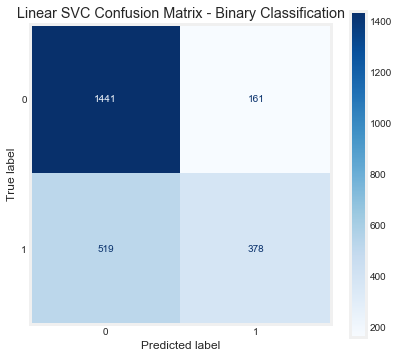

In [81]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(linear_svc, X_test_bin, y_test_bin, cmap='Blues', ax=ax)
plt.title('Linear SVC Confusion Matrix - Binary Classification')
plt.savefig('linear_svc_confusion_matrix.png')

Similar to both the Naive Bayes and random forest, the model does well in predicting the negative/neutral class and struggles to achieve the same performance when predicting positive tweets.

However, the linear SVM does have the best overall accuracy of any of the models so far at 72.7%. It performs noticeably better than any of the models trained on 3 classes.

We see that this model has a very high recall score of 90% for negative neutral/tweets! Out of all of the negative/neutral tweets in the test set, the model correctly predicted 90% of them. With 90% of negative tweets correctly identified, we can perform more exploratory data analysis to try and see why Twitter users don't have a favorable opinion of the brand.

Given that this model performed the best we will also take a look at the AUC and ROC curve.

In [109]:
feature_weights = list(linear_svc.coef_[0])
feat_coef_pair = list(zip(X_tfidf_df_bin.columns, feature_weights))

sorted_feats = sorted(feat_coef_pair, key=lambda x: x[1], reverse=True)


In [111]:
sorted_feats[:20]

[('cool', 4.274902735239113),
 ('smart', 4.148420803770919),
 ('great', 3.603728582854439),
 ('awesome', 3.3856039864541554),
 ('nice', 3.2825239553324708),
 ('love', 3.043830012141948),
 ('genius', 2.9628431053341333),
 ('amazing', 2.895054570283431),
 ('wow', 2.6500832803049974),
 ('congrats', 2.6017150795087307),
 ('woot', 2.5589612033364477),
 ('ill', 2.308438197747975),
 ('attendee', 2.2409347864610245),
 ('excited', 2.220775406416539),
 ('save', 2.1814536276479854),
 ('brilliant', 2.1808820870620016),
 ('sound', 2.1634620217808678),
 ('swarm', 2.1067210769539093),
 ('rock', 2.0861751391131533),
 ('sweet', 2.072432088375884)]

In [115]:
sorted_feats[-20:]

[('except', -1.1757656104583207),
 ('fail', -1.18180283024975),
 ('kicked', -1.1903217446068945),
 ('sort', -1.190781395941588),
 ('11', -1.213886895630999),
 ('created', -1.2183273833366512),
 ('twitter', -1.2735988175149595),
 ('realize', -1.281308824339781),
 ('art', -1.30026620520978),
 ('film', -1.3168101124971363),
 ('tattoo', -1.3385114577754664),
 ('size', -1.3426918167885502),
 ('battery', -1.355403195284056),
 ('challenge', -1.3654409770778395),
 ('yesterday', -1.3743077263399457),
 ('enough', -1.3854331608610153),
 ('spending', -1.4110659711647644),
 ('find', -1.5127722430230475),
 ('webdoccom', -1.5694445852028895),
 ('headache', -1.8005499331201753)]

In [87]:
y_test_bin.value_counts()

0    1602
1     897
Name: sentiment, dtype: int64

In [82]:
from sklearn.metrics import roc_curve, auc

y_score = linear_svc.decision_function(X_test_bin)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_score)

print(f"AUC: {auc(fpr, tpr)}")

AUC: 0.7583650314475913


We see that the AUC for the top performing model is 0.758 which is indicative that the model if fairly capable of distinguishing between classes. Although we would certainly like to see this number be a bit closer to 1, we can have some confidence in the model's predictability.

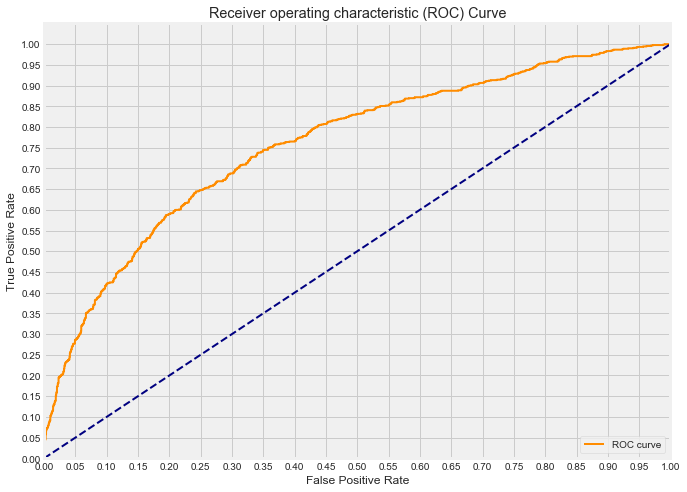

In [83]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')

The ROC curve further demonstrates that the model is better than a 50/50 guess. We would need to improve upon the recall rate for the positive class in order to improve the AUC and see an ROC curve that is indicative of strong model performance.

In [67]:
gs_linear = SVC()

In [73]:
linear_param = {'C':[0.1, 1, 10],
                     'kernel':['linear'], 
                    'class_weight':[None, 'balanced'], 
                    }

gs_linear_svc = GridSearchCV(gs_linear, param_grid=linear_param, cv=5, n_jobs=-1)
gs_linear_svc.fit(X_train_bin, y_train_bin)

gs_linear_svc.best_params_

{'C': 1, 'class_weight': None, 'kernel': 'linear'}

Running a GridSerach with the linear kernel returns that default parameters so we do not need to check classification metrics again.

In [57]:
rbf_svc = SVC(kernel='rbf')
rbf_svc.fit(X_train_bin, y_train_bin)

SVC()

In [58]:
rbf_svc_cv_mean = np.mean(cross_val_score(rbf_svc, X_train_bin, y_train_bin,
                                         cv=5, scoring='accuracy', n_jobs=-1))

In [59]:
print(f"Training Accuracy: {rbf_svc.score(X_train_bin, y_train_bin)}")
print(f"Cross Validation Mean Accuracy: {rbf_svc_cv_mean}")
print(f"Testing Accuracy: {rbf_svc.score(X_test_bin, y_test_bin)}")


Training Accuracy: 0.9257417252615332
Cross Validation Mean Accuracy: 0.717199839496973
Testing Accuracy: 0.7214885954381752


The RBF kernel SVM performs slightly worse than the linear SVM in terms of accuracy for binary classification.  This is the opposite of what we saw when modeling with 3 classes, as it was the RBF kernel that had a slightly improved accuracy.

### Oversampling with Two Classes

See below for the value counts of each class for our binary model. Here the minority class (positive tweets) makes up 35% of the data while the negative class makes up 65%. We again have a class imbalance, so we should check to see if oversampling will increase model performance.

It's important to note here that the GridSearch peformed on the linear SVM did NOT return `balanced` for the class weight hyperparameter. This means that the optimized model was able to determine some linear separation between the two classes without accounting for the difference in class quantity.

Here, I will choose to make the two classes equal and train a linear SVM model to see if it outperforms the linear SVM trained and tests on the original data.

In [68]:
from imblearn.over_sampling import RandomOverSampler

In [88]:
y_binary.value_counts()

0    5341
1    2989
Name: sentiment, dtype: int64

In [69]:
y_train_bin.value_counts()

0    3739
1    2092
Name: sentiment, dtype: int64

In [70]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=123)
X_over_train, y_over_train = oversample.fit_resample(X_train_bin, y_train_bin)

In [71]:
y_over_train.value_counts()

1    3739
0    3739
Name: sentiment, dtype: int64

In [76]:
svc_over = SVC(kernel='linear', C=1)
svc_over.fit(X_over_train, y_over_train)

SVC(C=1, kernel='linear')

In [77]:
svc_over_cv_mean = np.mean(cross_val_score(svc_over, X_over_train, y_over_train,
                                          cv=5, scoring='accuracy', n_jobs=-1))

In [78]:
print(f"Training Accuracy: {svc_over.score(X_over_train, y_over_train)}")
print(f"Cross Validation Mean: {svc_over_cv_mean}")
print(f"Testing Accuracy: {svc_over.score(X_test_bin, y_test_bin)}")

Training Accuracy: 0.8892752072746724
Cross Validation Mean: 0.7674633806091606
Testing Accuracy: 0.7058823529411765


Here we did have an improvment in the cross validation accuracy of the model, but we can see from the test accuracy that we did again have overfitting. Clearly, oversampling is not a feasible method for improving model performance. It could be that we oversampled too much, but if we oversampled too little we might only see marginal improvements.  It would be better to get more data or to use some technique like Named Entity Recognition to create synthetic tweets where certain words have been replaced with their synonyms.

### Removing Common Words

Here we will use binary modeling with a TF-IDF vector but we will remove 4 common words found in across all sentiments.

In [89]:
stopwords = nltk.corpus.stopwords.words('english')

In [91]:
#add twitter stopwords to stopwords list
twitter_stopwords = ['rt', 'sxsw', 'mention', 'link']
stopwords.extend(twitter_stopwords)

In [93]:
#create TF-IDF matrix
tfidf_vec_2 = TfidfVectorizer(stop_words=stopwords)
X_tfidf_2 = tfidf_vec_2.fit_transform(df_binary['tweet_tokens'])
X_tfidf_df_2 = pd.DataFrame(X_tfidf_2.toarray())
X_tfidf_df_2.columns = tfidf_vec_2.get_feature_names()

In [94]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tfidf_df_2, y_binary, test_size=0.3, 
                                                                    stratify=y_binary, random_state=123)

In [96]:
svc_linear_2 = SVC(kernel='linear', C=1)
svc_linear_2.fit(X_train_2, y_train_2)

SVC(C=1, kernel='linear')

In [97]:
svc_linear_2_cv_mean = np.mean(cross_val_score(svc_linear_2, X_train_2, y_train_2, cv=5, scoring='accuracy'))

In [98]:
print(f"Training Accuracy: {svc_linear_2.score(X_train_2, y_train_2)}")
print(f"Cross Validation Average: {svc_linear_2_cv_mean}")
print(f"Testing Accuracy: {svc_linear_2.score(X_test_2, y_test_2)}")

Training Accuracy: 0.8617732807408678
Cross Validation Average: 0.7209734244026333
Testing Accuracy: 0.7274909963985594


In [99]:
print(classification_report(y_test_2, svc_linear_2.predict(X_test_2)))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1602
           1       0.70      0.43      0.53       897

    accuracy                           0.73      2499
   macro avg       0.72      0.66      0.67      2499
weighted avg       0.72      0.73      0.71      2499



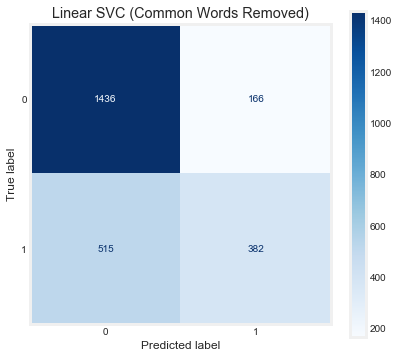

In [100]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(svc_linear_2, X_test_2, y_test_2, cmap='Blues', ax=ax)
plt.title('Linear SVC (Common Words Removed)')
plt.savefig('Common_words_removed_conf_matrix.png')

In [101]:
y_score_2 = svc_linear_2.decision_function(X_test_2)
fpr, tpr, thresholds = roc_curve(y_test_2, y_score_2)

print(f"AUC: {auc(fpr, tpr)}")

AUC: 0.7566621711712087


By adding just 4 words to the `stopwords` list, we don't see much of a change to the overall model accuracy.  The difference between the cross validation mean accuracy and testing accuracy was decreased, however the testing accuracy was slightly lower. We can see from the confusion matrix, that 4 more positive tweets were correctly identified, so there is reason to believe that the removal of other heavily used words might help make a tweet more distinguishable.

# Conclusion

Our best model had a 72.7% overall accuracy with 90% recall on negative/neutral tweets and 70% precision on positive tweets.

The best performing model was a support vector machine with a linear kernel.  Although it was the best performing model, the major drawback to the support vector machine it the computation time.  Large tech companies definitely have the resources such that they could use an SVM and have it make predictions in a reasonable amount of time, however with tweets now having a maximum character length of 280 characters other, more efficient model architectures should be explored.

## Recommendations

1. When releasing a new hardware, make sure there is some type of accompanying software.  For both Apple and Google, the tweets about services and mobile apps were overwhemingly positive. If a good app exists, then that will only provide more incentive to buy your product.

2. Determine ways to guide conversations about your product on social media. Before their next iPhone event, Apple could tweet something along the lines of, "Give us 5 reasons why you're excited for the new iPhone and use the hashtag #TeamiPhone". In this example we have used a word that conveys positive emotion ('excited') and we have also created a readily identifiable token with a hashtag. We also can use a similar message to identify users who may be on the fence.  We want to avoid provoking users to make negative tweets but we can ask for feedback by saying something like, "Tell us what improvements you want to see in the next iPhone #iPhoneEvolution". We again have another unique hashtag which should make those tweets easy to identify and also quantify what may lacking in hardware or user experience without asking for negative feedback. 

3. It is imperative that when releasing a new product it is both innovative and improves upon the previous version in some way. The word 'battery' shows up as one of the top 20 most negative features and the negative WordCloud also included the bigram "battery life". Cell phones are arguable the most important tool in modern society and mobility is one of the most import features of the cell phone.  The convenience of mobility ceases to exist if the phone (or any other mobile device) has to be repeatedly plugged into a wall.  

4. Avoid the development of another social network or partnering with existing social networks. Interestingly enough, the word 'twitter' is a top 20 negative feature and the bigrams 'new social' and 'social network' were of moderate significance in the wordcloud based on their size. The optimized model has reinforced what we observed in EDA so at this time is appears that social media should not be on of the app focuses as noted in recommendation #1.




## Future Work

- Developing a script to get tweets from Twitter's API and evaluate those tweets once a certain number of tweets have been collected
    - For example we could have a script that can get tweets centered around a certain topic and evaluate sentiment on those tweets made in a certain time interval or evaluate sentiment on the 100,000 most recent tweets about a subject.
    
- Building a model to evaluate sentiment from other forms of social media
    - Since the pandemic started, Apple had broadcasted all of their events during a livestream on Youtube. It would definitely be helpful to evaluate sentiment for the thousands of comments made during the livestream as well as the subsequent comments made at a later time.
    
- Using Named Entity Recognition to create synthetic tweets

- Building, testing, and training a BERT model to predict sentiment

- Adding a time series component to see how opinions of brands/products change over time
- Evaluate engagement metrics (replies, retweets, and likes) for tweets to understand if those features impact sentiment predictability